# Florence 2 Test

https://huggingface.co/microsoft/Florence-2-base

In [1]:
import requests
import time

import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import AutoProcessor, AutoModelForCausalLM 

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [3]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

/home/jifeng/florence/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
prompt = "<OD>"

In [5]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

In [6]:
#url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/boat.jpg?download=true"
url = "http://farm8.staticflickr.com/7064/7122717521_1137529e56_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

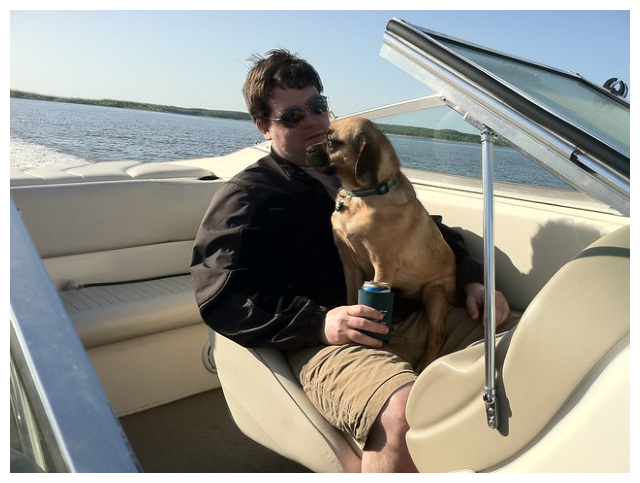

In [7]:
# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
#plt.title("Image")
plt.show()

In [8]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

print(parsed_answer)

{'<OD>': {'bboxes': [[0.3199999928474426, 8.842999458312988, 639.0399780273438, 477.2829895019531], [304.9599914550781, 111.13499450683594, 464.3199768066406, 377.3809814453125], [342.7200012207031, 174.23098754882812, 402.239990234375, 194.7849884033203], [185.9199981689453, 41.82499694824219, 520.0, 477.2829895019531], [262.0799865722656, 89.625, 330.55999755859375, 123.08499908447266], [359.3599853515625, 280.34698486328125, 397.1199951171875, 345.35498046875]], 'labels': ['boat', 'dog', 'dog collar', 'person', 'sunglasses', 'tin can']}}


In [9]:
parsed_answer['<OD>']

{'bboxes': [[0.3199999928474426,
   8.842999458312988,
   639.0399780273438,
   477.2829895019531],
  [304.9599914550781,
   111.13499450683594,
   464.3199768066406,
   377.3809814453125],
  [342.7200012207031, 174.23098754882812, 402.239990234375, 194.7849884033203],
  [185.9199981689453, 41.82499694824219, 520.0, 477.2829895019531],
  [262.0799865722656, 89.625, 330.55999755859375, 123.08499908447266],
  [359.3599853515625, 280.34698486328125, 397.1199951171875, 345.35498046875]],
 'labels': ['boat', 'dog', 'dog collar', 'person', 'sunglasses', 'tin can']}

In [10]:
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

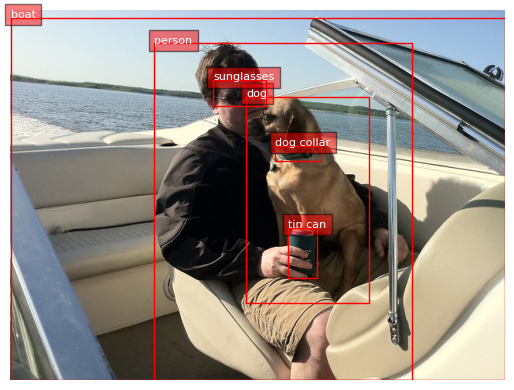

In [11]:
plot_bbox(image, parsed_answer['<OD>'])

In [12]:
def run_example(task_prompt, text_input=None):
    start_time = time.perf_counter()  # Start timing
    
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    print(parsed_answer)

    end_time = time.perf_counter()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f" \n[INFO] ==> Florence-2-base ({task_prompt}), took {elapsed_time:.1f} seconds to execute.\n")
    
    return parsed_answer

In [13]:
prompt = "<CAPTION>"
results = run_example(prompt)

{'<CAPTION>': 'A man sitting in a boat with a dog on his lap.'}
 
[INFO] ==> Florence-2-base (<CAPTION>), took 14.6 seconds to execute.



In [14]:
prompt = "<DETAILED_CAPTION>"
results = run_example(prompt)

{'<DETAILED_CAPTION>': 'The image shows a man sitting in a boat with his dog, wearing goggles and holding a tin in his hand. The boat is on the water, with trees and a clear blue sky in the background.'}
 
[INFO] ==> Florence-2-base (<DETAILED_CAPTION>), took 25.2 seconds to execute.



In [15]:
prompt = "<MORE_DETAILED_CAPTION>"
results = run_example(prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a young man sitting in the back of a boat with his dog. The man is wearing a black jacket, khaki shorts, and sunglasses. He is holding a can of beer in his left hand and is kissing the dog on the cheek. The dog is a brown Labrador Retriever with a green collar around its neck. The boat is on a lake with a clear blue sky in the background. The interior of the boat is beige and there is a metal railing on the right side of the image.'}
 
[INFO] ==> Florence-2-base (<MORE_DETAILED_CAPTION>), took 40.7 seconds to execute.



In [16]:
task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building.")

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[0.3199999928474426, 7.886999607086182, 639.0399780273438, 477.2829895019531]], 'labels': ['A green car']}}
 
[INFO] ==> Florence-2-base (<CAPTION_TO_PHRASE_GROUNDING>), took 14.9 seconds to execute.



In [17]:
results['<CAPTION_TO_PHRASE_GROUNDING>']

{'bboxes': [[0.3199999928474426,
   7.886999607086182,
   639.0399780273438,
   477.2829895019531]],
 'labels': ['A green car']}

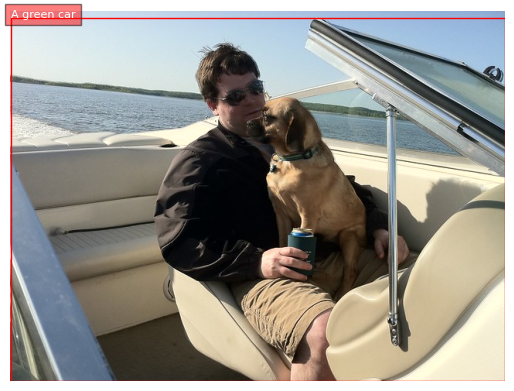

In [18]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])